# The Effect of the MMP Program in CA

*Author: Nicole Lin*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn import preprocessing
import datetime as dt

# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
import warnings
warnings.filterwarnings('ignore')

## Difference in Differences 

1. Outcome variables
    - Facility level: 
        - count of MMP violations
        - count of Non-MMMP violations 
        - ratio of effluent parameters in MMP violations
        - ratio of effluent parameteres in non-MMP violations 
        - aggregate exceedence percentages
2. Treatment: MMP Initiative in 2007
3. Treated Regions: 2, 3, 4, 5 
4. Control Regions: all other regions in CA
3. Conditional on municipal large wastewater treatment plants (WWTPs) that were active before and after treatment.

### Prepare data

In [2]:
data_dir = os.path.join('~', 'sherlock_oak', 'EPA', 'Data', 'processed', 'california')
violations = pd.read_csv(os.path.join(data_dir, 'violations_2022-01-13.csv'))
facilities = pd.read_csv(os.path.join(data_dir, 'facilities_2022-01-13.csv'))
wwtp_consistent = pd.read_csv(os.path.join(data_dir, 'wwtp_consistent_2022-01-13.csv'))

In [3]:
violations.head()

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,COMPLEXITY,FACILITY WASTE TYPE,PROGRAM,PROGRAM CATEGORY,WDID_x,REG MEASURE TYPE,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,STATUS,INDIVIDUAL/GENERAL,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,OCCURRED ON,DISCOVERY DATE,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,Violation Type,Priority Violation,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,Discovery Date,mmp_flag,enforced_flag,violation_year,enforcement_year,viol_to_enf_time,enforcement_agency,violation_category,region_group,enforced_within_period,days_to_enf,npdes_flag,wwtp_flag
0,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,181762,Effluent,CAT1,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,2001-04-30,2001-05-31,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-04-30,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-31,True,True,2001,2001.0,172 days 00:00:00.000000000,R8,Effluent,Region 8,True,172.0,True,True
1,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188721,Effluent,CAT1,Exceeded 12-month average Sodium limit for Feb...,"Also, Board staff will issue a mandatory penal...",NaN,2001-02-07,2001-05-08,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-02-07,Exceeded 12-month average Sodium limit for Feb...,"Also, Board staff will issue a mandatory penal...",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
2,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188789,Effluent,CAT1,Exceeded 12-month average Sulfate limit for Fe...,"Also, Board staff will issue a mandatory penal...",NaN,2001-02-07,2001-05-08,Y,Y,N,N,NaN,Serious,Water Quality -> Effluent -> CAT1,Y,2001-02-07,Exceeded 12-month average Sulfate limit for Fe...,"Also, Board staff will issue a mandatory penal...",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days 00:00:00.000000000,R8,Effluent,Region 8,True,254.0,True,True
3,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permits,CA0063185,Major,OTH,Historical,I,200268,Reporting,Late Report,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,2001-07-01,2002-01-07,N,N,N,N,NaN,Non-MMP,Reporting -> Late Report,3,2001-07-01,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,240323,Notice of Violation,NOV,2002-01-07,2002-01-07,False,True,2001,2002.0,190 days 00:00:00.000000000,NOV,Reporting,"Region 2, 3, 4, 5",True,190.0,True,False
4,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permits,CA0063185,Major,OTH,Historical,I,200269,Reporting,Late Report,July 2001 DMR submitted 20 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,2001-08-01,2002-01-07,N,N,N,N,NaN,Non-MMP,Reporting -> Late Report,3,

In [4]:
wwtp_consistent.head()

,WDID,start_date,end_date,Region,Program,Status,active_flag,region_group,active_days,active_years,active_before_2007,active_after_2007
0,1A84006ODN,1984-01-19,2022-03-31,1,NPDMUNILRG,Active,True,Other,13951.0,38.221918,True,True
1,1B80078OMEN,1985-07-25,2020-11-30,1,NPDMUNILRG,Active,False,Other,12912.0,35.375342,True,True
2,1B82037OSON,1982-04-22,2025-09-30,1,NPDMUNILRG,Active,True,Other,15867.0,43.471233,True,True
3,1B82046OSON,1982-04-22,2021-07-31,1,NPDMUNILRG,Active,True,Other,14345.0,39.301370,True,True
4,1B82084OHUM,1982-07-22,2023-10-31,1,NPDMUNILRG,Active,True,Other,15076.0,41.304110,True,True


In [5]:
# conditional on WWTP 
## violations (effluent MMP)
viol_wwtp = violations[(violations.WDID_x.isin(wwtp_consistent.WDID)) & (violations['VIOLATION TYPE'] == 'Effluent') & (violations.mmp_flag)]
data = viol_wwtp.groupby(['WDID_x', 'region_group', 'violation_year', 'mmp_flag'])['wwtp_flag'].count().to_frame().reset_index()
data = data.rename(columns = {'WDID_x': 'WDID', 'wwtp_flag': 'violation_count'})
data['treatment_group'] = np.where(data.region_group == 'Region 2, 3, 4, 5', 1, 0)
data['treatment_time'] = np.where(data.violation_year >= 2008, 1, 0)
data['did'] = data['treatment_group'] * data['treatment_time']

## facilities
wwtp_consistent.start_date = pd.to_datetime(wwtp_consistent.start_date)
wwtp_consistent.end_date = pd.to_datetime(wwtp_consistent.end_date)
years = range(2000, 2022, 1)
counts = []
for y in years:
    y_start = dt.datetime(y, 1, 1)
    y_end = dt.datetime(y, 12, 30)
    wwtp_consistent['active_flag'] = (wwtp_consistent.start_date <= y_end) & ((wwtp_consistent.end_date >= y_start) | (pd.isnull(wwtp_consistent.end_date)))
    df = wwtp_consistent.groupby(['region_group'])['active_flag'].sum().to_frame().reset_index()
    df = df.rename(columns = {'active_flag': 'permit_count'})
    df['year'] = y
    df = df[['year', 'region_group', 'permit_count']]
    counts.append(df)
wwtp_count = pd.concat(counts)

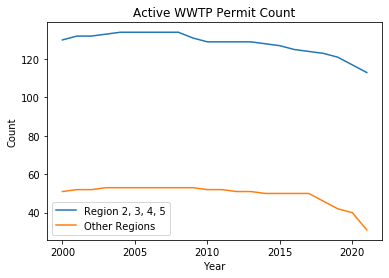

In [6]:
# plot facility counts by group across time
plt.title('Active WWTP Permit Count')
plt.plot(wwtp_count[wwtp_count.region_group == 'Region 2, 3, 4, 5'].year, wwtp_count[wwtp_count.region_group == 'Region 2, 3, 4, 5'].permit_count)
plt.plot(wwtp_count[wwtp_count.region_group == 'Other'].year, wwtp_count[wwtp_count.region_group == 'Other'].permit_count)
plt.legend(['Region 2, 3, 4, 5', 'Other Regions'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

> Active WWTP count almost doubles in the treated regions. Implications? 

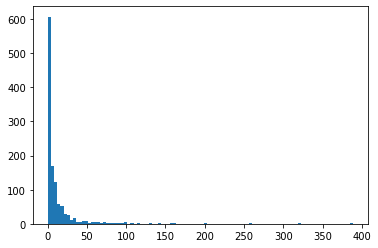

In [7]:
# plot distribution of violation counts
plt.hist(data.violation_count, bins = 100)
plt.show()

In [8]:
data.violation_count.describe()

count    1166.000000
mean       11.548885
std        24.825273
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max       388.000000
Name: violation_count, dtype: float64

In [9]:
q1 = np.percentile(data.violation_count, 25)
q3 = np.percentile(data.violation_count, 75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
print(f'Outlier bounds: upper = {upper}; lower = {lower}')

Outlier bounds: upper = 28.5; lower = -15.5


In [10]:
# remove outliers
data_trim = data[(data.violation_count >= lower) & (data.violation_count <= upper)]
print(f'{sum((data.violation_count < lower) | (data.violation_count > upper))} records removed')
data_trim.violation_count.describe()

101 records removed


count    1065.000000
mean        6.189671
std         6.474189
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max        28.000000
Name: violation_count, dtype: float64

"
In February 2008, the State Water Board’s Office of Enforcement (OE) began examining many of the violations subject to MMPs in the California Integrated Water Quality System (CIWQS) dating back to January 1, 2000 that had not received an enforcement action to assess a MMP. After discussing the ways to efficiently address these outstanding violations, the Water Boards started the Statewide Initiative for MMP Enforcement (Initiative).

The Initiative’s goal was to substantially reduce the MMP enforcement backlog by December 31, 2008. Violations occurring on or before December 31, 2007 were considered backlogged violations for the purposes of the Initiative. For administrative efficiency and taking advantage of the enforcement focus offered by the Initiative, several regions used the Initiative to address MMP violations that occurred after December 31, 2007.
"
- https://www.waterboards.ca.gov/water_issues/programs/enforcement/docs/mmpdraftreport.pdf

In [11]:
# clarify treatment time (date)
df = viol_wwtp[(viol_wwtp.enforced_flag) & (viol_wwtp['Enforcement Action'].isin(['Admin Civil Liability', 'Expedited Payment Letter']))]
df['EA Effective Date'] = pd.to_datetime(df['EA Effective Date'])
## treated regions by facility count
df[df.region_group == 'Region 2, 3, 4, 5'].groupby(['EA Effective Date', 'WDID_x'])['mmp_flag'].count().to_frame().reset_index().groupby(['EA Effective Date'])['WDID_x'].count().sort_values(ascending = False)[:10]

EA Effective Date
2008-11-19    19
2011-03-14     5
2004-06-25     5
2001-04-16     5
2013-01-11     5
2011-01-07     4
2003-07-02     4
2012-01-05     4
2008-11-10     4
2011-05-06     4
Name: WDID_x, dtype: int64

In [12]:
# by violation count
df[df.region_group == 'Region 2, 3, 4, 5'].groupby(['EA Effective Date'])['mmp_flag'].count().sort_values(ascending = False)[:10]

EA Effective Date
2008-05-05    405
2005-04-15    356
2003-08-06    293
2012-12-04    230
2011-02-04    209
2014-05-15    197
2011-02-23    195
2006-12-15    194
2017-01-23    165
2015-06-10    163
Name: mmp_flag, dtype: int64

In [13]:
df[(df['EA Effective Date'] == pd.to_datetime('2008-11-19')) & (df.region_group == 'Region 2, 3, 4, 5')]['enforcement_agency'].value_counts()

SWB    72
R5     11
Name: enforcement_agency, dtype: int64

In [14]:
df.enforcement_year.value_counts()

2008.0    1863
2005.0    1183
2011.0    1128
2012.0     686
2006.0     676
2003.0     649
2009.0     625
2001.0     605
2015.0     565
2020.0     556
2013.0     526
2007.0     377
2014.0     370
2019.0     323
2017.0     316
2002.0     310
2004.0     305
2000.0     284
2016.0     188
2010.0     162
2021.0     149
2018.0     134
Name: enforcement_year, dtype: int64

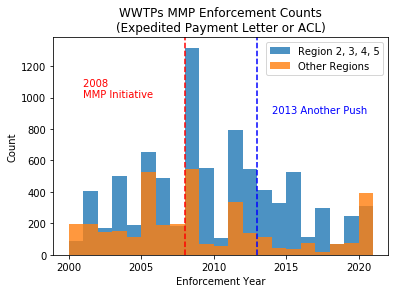

In [15]:
n_bins = len(df.enforcement_year.unique())
plt.title('WWTPs MMP Enforcement Counts\n(Expedited Payment Letter or ACL)')
plt.hist(df[df.region_group == 'Region 2, 3, 4, 5']['enforcement_year'], bins = n_bins-1, alpha = 0.8)
plt.hist(df[df.region_group != 'Region 2, 3, 4, 5']['enforcement_year'], bins = n_bins-1, alpha = 0.8)
plt.legend(['Region 2, 3, 4, 5', 'Other Regions'])
plt.axvline(x = 2008,color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (2001, 1000), color = 'red')
plt.axvline(x = 2013,color = 'blue',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 900), color = 'blue')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

In [16]:
# control regions
df = viol_wwtp[(viol_wwtp.enforced_flag) & (viol_wwtp.region_group != 'Region 2, 3, 4, 5')]
df['EA Effective Date'] = pd.to_datetime(df['EA Effective Date'])
## by facility count
df.groupby(['EA Effective Date', 'WDID_x'])['mmp_flag'].count().to_frame().reset_index().groupby(['EA Effective Date'])['WDID_x'].count().sort_values(ascending = False)[:10]

EA Effective Date
2000-07-31    3
2004-03-09    3
2011-07-12    2
2007-05-18    2
2004-11-16    2
2012-04-25    2
2005-12-30    2
2003-12-19    2
2016-09-20    2
2016-10-04    2
Name: WDID_x, dtype: int64

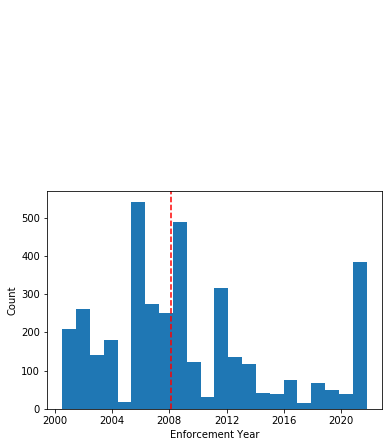

In [17]:
n_bins = len(df.enforcement_year.unique())
plt.hist(df['EA Effective Date'], bins = n_bins)
#plt.hist(df[df.region_group != 'Region 2, 3, 4, 5']['EA Effective Date'], bins = n_bins)
plt.axvline(x = pd.to_datetime('2008-02-01'),color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (pd.to_datetime('2001-01-01'), 1000), color = 'red')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

5S    2908
4     1717
1      322
2      173
7      171
8      132
9      121
6B      96
5F      72
5R      71
3       35
Name: VIOLATED FACILITY REGION, dtype: int64


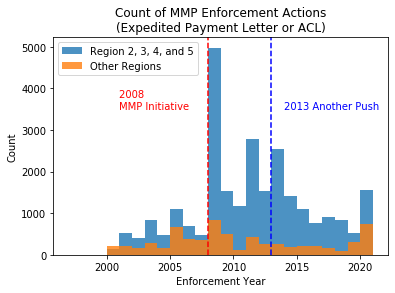

In [18]:
# 2008 MMP initiative
## focusing on Regions 2, 3, 4, and 5

df = violations[(violations.mmp_flag) & (violations.enforced_flag) & (violations['Enforcement Action'].isin(['Admin Civil Liability', 'Expedited Payment Letter']))]
print(df[df.enforcement_year == 2008]['VIOLATED FACILITY REGION'].value_counts())

# count of enforcement actions for mmp violations over time in region 2, 3, 4, and 5
plt.title('Count of MMP Enforcement Actions\n(Expedited Payment Letter or ACL)')
plt.hist(df[df.region_group == 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique()), alpha = 0.8)
plt.hist(df[df.region_group != 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique())-3, alpha = 0.8)
plt.legend(['Region 2, 3, 4, and 5', 'Other Regions'])
plt.axvline(x = 2008,color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (2001, 3500), color = 'red')
plt.axvline(x = 2013,color = 'blue',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 3500), color = 'blue')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

### Modeling

In [120]:
data.head()

,WDID,region_group,violation_year,mmp_flag,violation_count,treatment_group,treatment_time,did
0,1A84006ODN,"Region 1, 3, 7",2003,True,6,0,0,0
1,1A84006ODN,"Region 1, 3, 7",2005,True,5,0,0,0
2,1A84006ODN,"Region 1, 3, 7",2006,True,9,0,0,0
3,1A84006ODN,"Region 1, 3, 7",2007,True,12,0,1,0
4,1A84006ODN,"Region 1, 3, 7",2008,True,31,0,1,0


In [127]:
# this is not clustered on facility 
X = sm.add_constant(data[['treatment_group', 'treatment_time', 'did']])
y = data['violation_count']
# normalize y
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        violation_count   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.981
Date:                Fri, 14 Jan 2022   Prob (F-statistic):            0.00194
Time:                        10:46:32   Log-Likelihood:                -5391.6
No. Observations:                1166   AIC:                         1.079e+04
Df Residuals:                    1162   BIC:                         1.081e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              19.6218      2.264      8.666      0.000      15.180      24.064
treatment_group    -8.2613      2.595     -3.184      0.001     -13.352      -3.171
treatment_time     -8.6518      2.859     -3.026      0.003     -14.262      -3.042
did                 7.1843      3.330      2.157      0.031       0.651      13.718
==============================================================================
Omnibus:                     1571.950   Durbin-Watson:                   1.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           318798.500
Skew:                           7.337   Prob(JB):                         0.00
Kurtosis:                      82.665   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
# check effect size
pre_treat = data[(data.treatment_group == 1) & (data.treatment_time == 0)].violation_count
pre_con = data[(data.treatment_group == 0) & (data.treatment_time == 0)].violation_count
post_treat = data[(data.treatment_group == 1) & (data.treatment_time == 1)].violation_count
post_con = data[(data.treatment_group == 0) & (data.treatment_time == 1)].violation_count
(post_treat.mean() - pre_treat.mean()) - (post_con.mean() - pre_con.mean())

7.184256042550009

(array([47., 38., 37.,  0., 11., 10.,  0.,  7.,  1.,  2.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

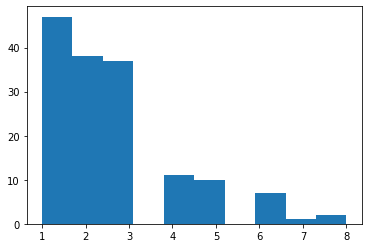

In [110]:
plt.hist(pre_con)

(array([119.,  69.,  74.,   0.,  18.,   8.,   0.,   8.,   1.,   1.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

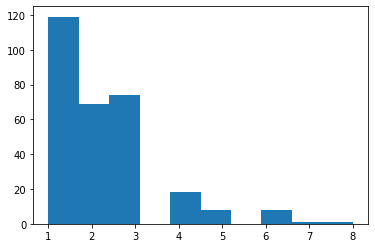

In [111]:
plt.hist(post_con)